# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

from sklearn.preprocessing import LabelEncoder

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
tqdm.pandas()

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Load Data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
display(df_reviews)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47326,tt0068398,tvEpisode,Étude in Black,Étude in Black,1972,\N,97,0,"Crime,Drama,Mystery",7.7,2254,This is another of my favorite Columbos. It sp...,10,pos,1,test,6038
47327,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,Talk about being boring! I got this expecting ...,4,neg,0,test,989
47328,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,"I never thought I'd say this about a biopic, b...",8,pos,1,test,4163
47329,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,Spirit and Chaos is an artistic biopic of Miya...,9,pos,1,test,4164


In [6]:
df_reviews.isna().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [7]:
df_reviews.query('average_rating != average_rating')

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
22280,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,NaN,"This is a truly great film, with excellent dir...",9,pos,1,test,3231
22281,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,NaN,"A film is beyond all expectations, an excellen...",10,pos,1,test,3232


In [8]:
print(df_reviews.duplicated().sum())

0


In [9]:
df_reviews.dtypes

tconst              object
title_type          object
primary_title       object
original_title      object
start_year           int64
end_year            object
runtime_minutes     object
is_adult             int64
genres              object
average_rating     float64
votes                Int64
review              object
rating               int64
sp                  object
pos                  int64
ds_part             object
idx                  int64
dtype: object

## EDA

Let's check the number of movies and reviews over years.

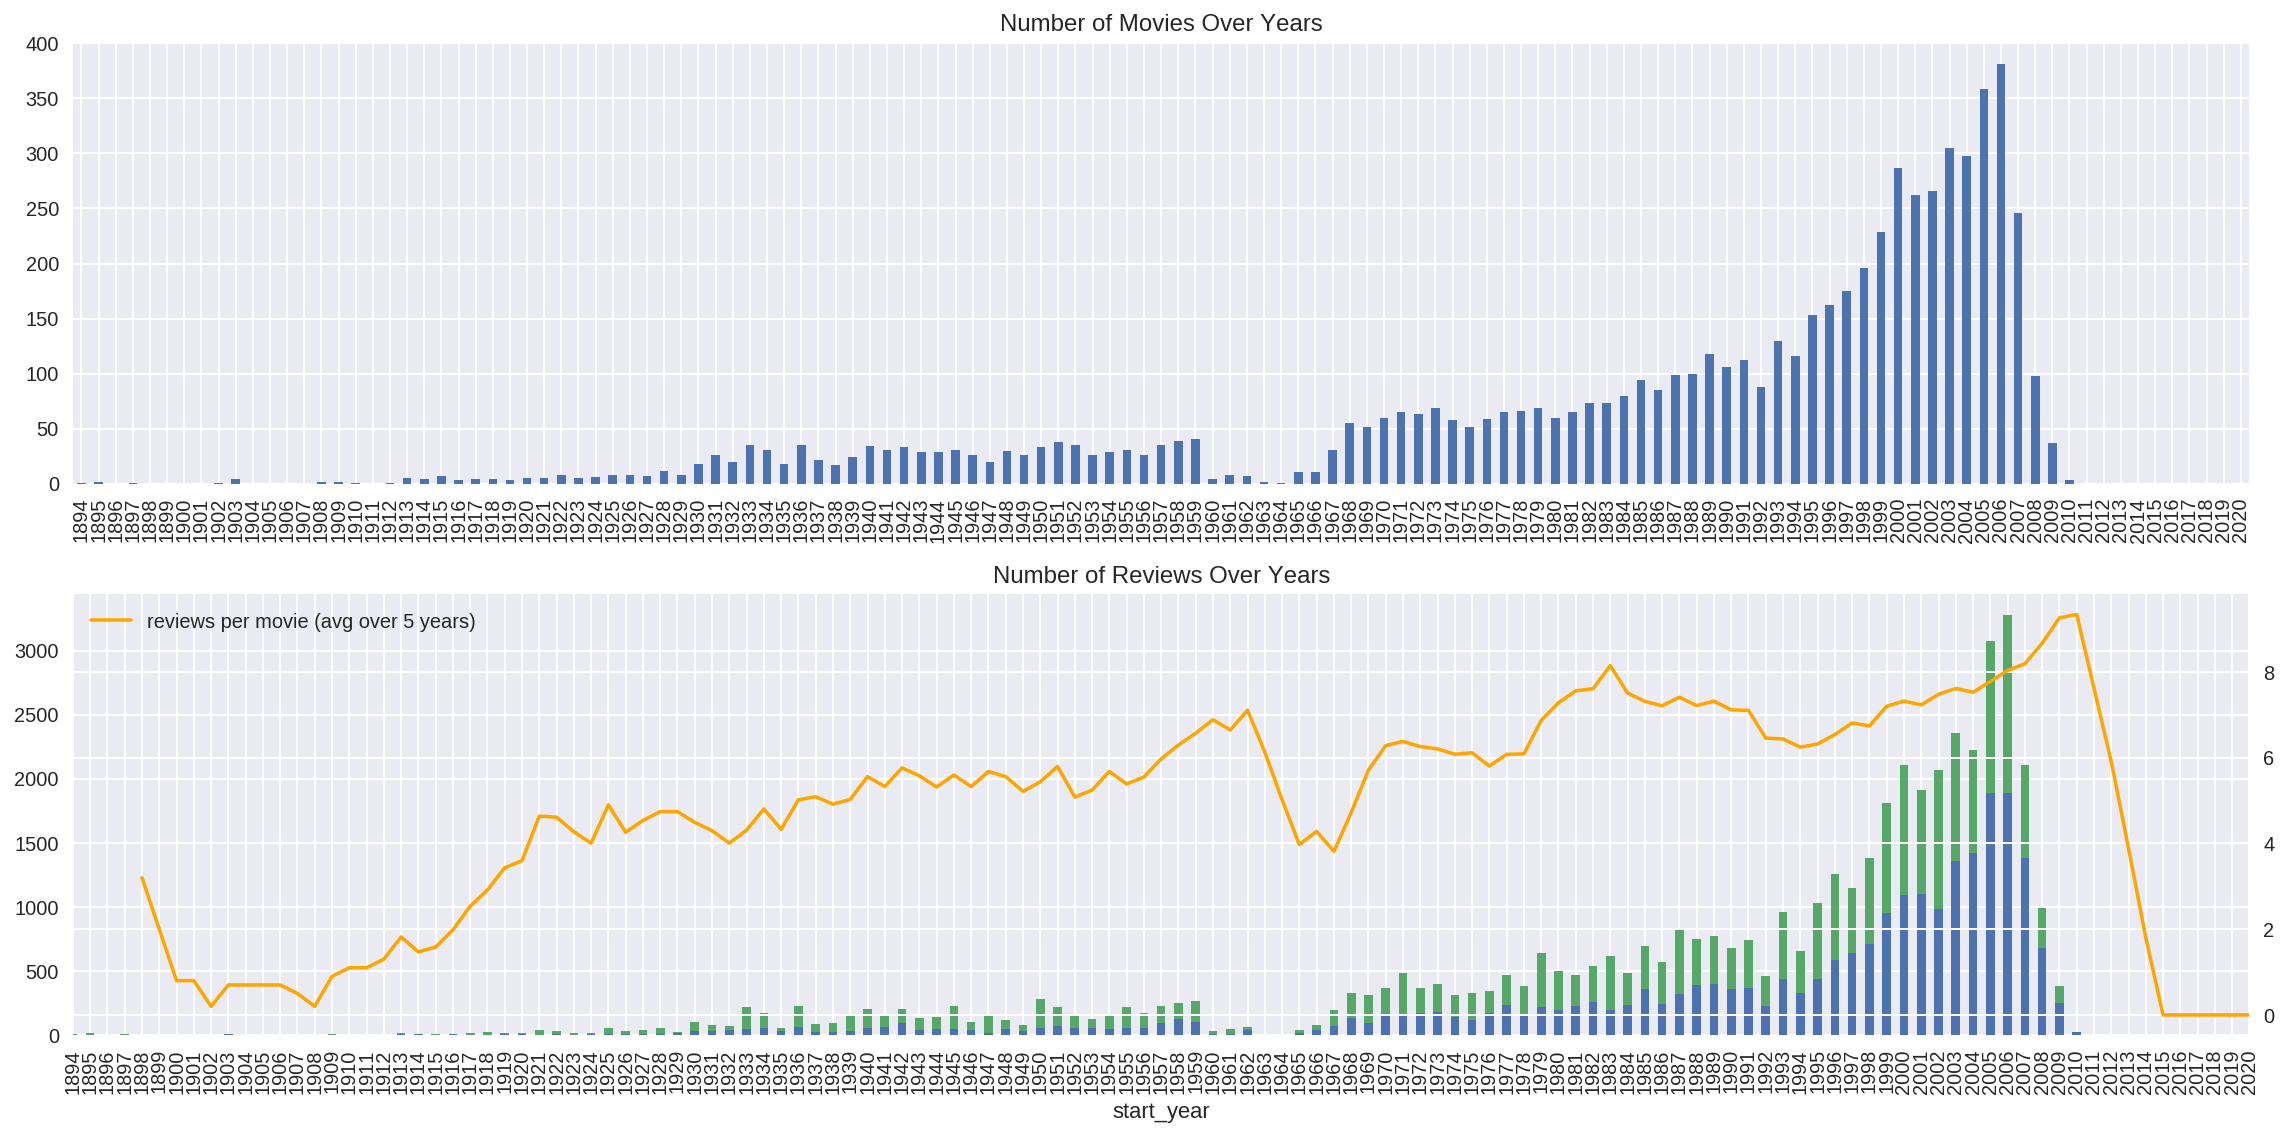

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

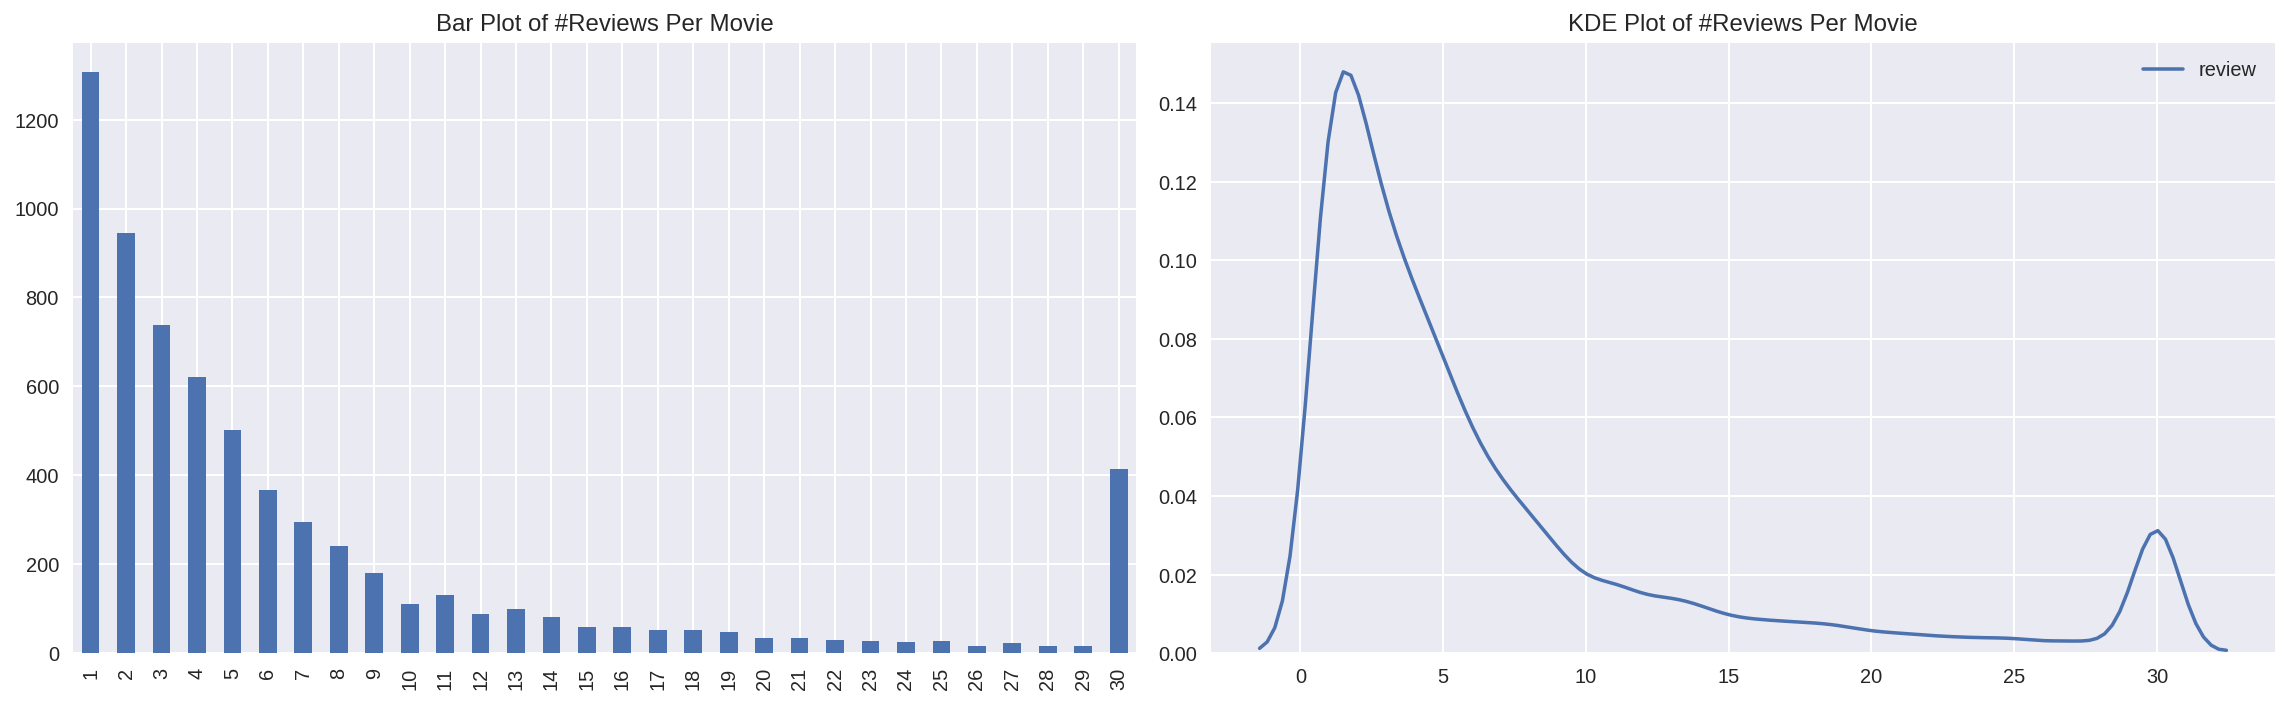

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

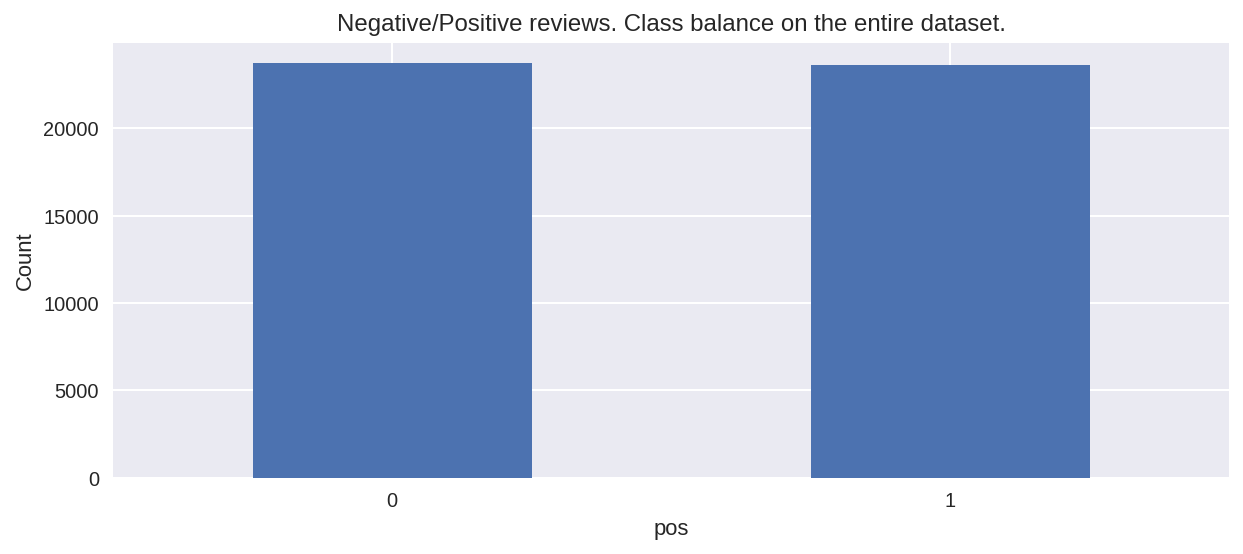

In [12]:
#PLOTTING THE TARGET.
count_target = pd.value_counts(df_reviews.pos, sort=True)
plt.figure(figsize=(10,4))
count_target.plot(kind='bar', rot=0)
plt.title('Negative/Positive reviews. Class balance on the entire dataset.')
plt.xlabel('pos')
plt.ylabel('Count')
plt.show()

In [14]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

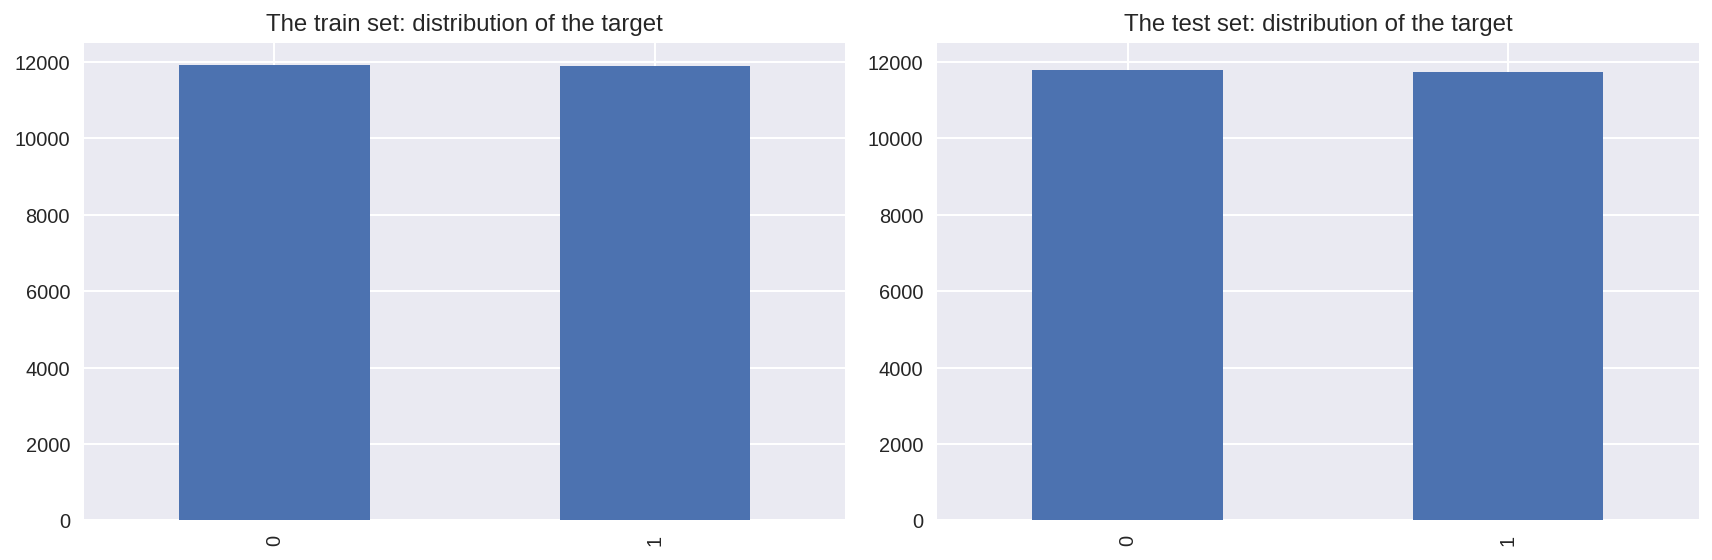

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
balance = df_reviews.query('ds_part == "train"')['pos'].value_counts().sort_index()
balance.plot.bar(ax=ax)
ax.set_ylim([0, 12500])
ax.set_title('The train set: distribution of the target')

ax = axs[1]
balance = df_reviews.query('ds_part == "test"')['pos'].value_counts().sort_index()
balance.plot.bar(ax=ax)
ax.set_ylim([0, 12500])
ax.set_title('The test set: distribution of the target')

fig.tight_layout()

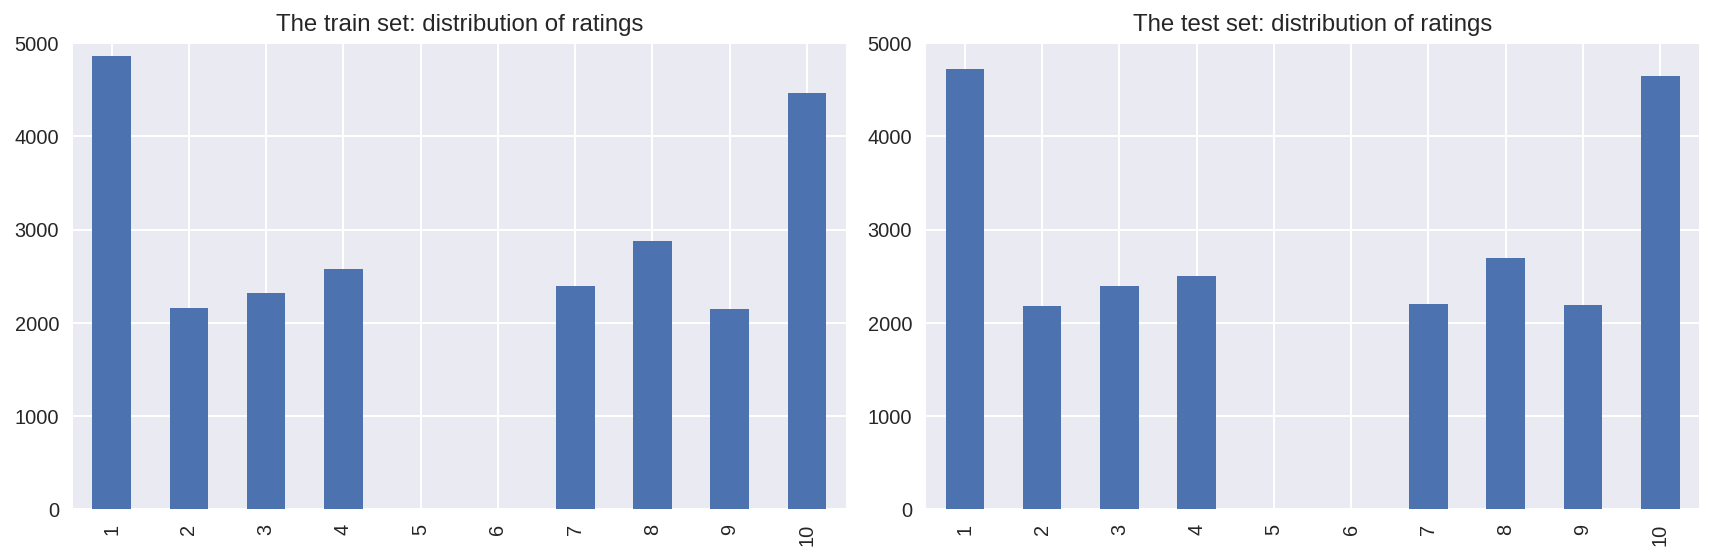

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

In [16]:
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
print('Training set:')
print(dft)
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
print()
print('Testing set:')
print(dft)

Training set:
1     4863
2     2155
3     2317
4     2577
7     2393
8     2876
9     2153
10    4462
Name: rating, dtype: int64

Testing set:
1     4726
2     2184
3     2392
4     2501
7     2200
8     2700
9     2190
10    4642
Name: rating, dtype: int64


Distribution of negative and positive reviews over the years for two parts of the dataset

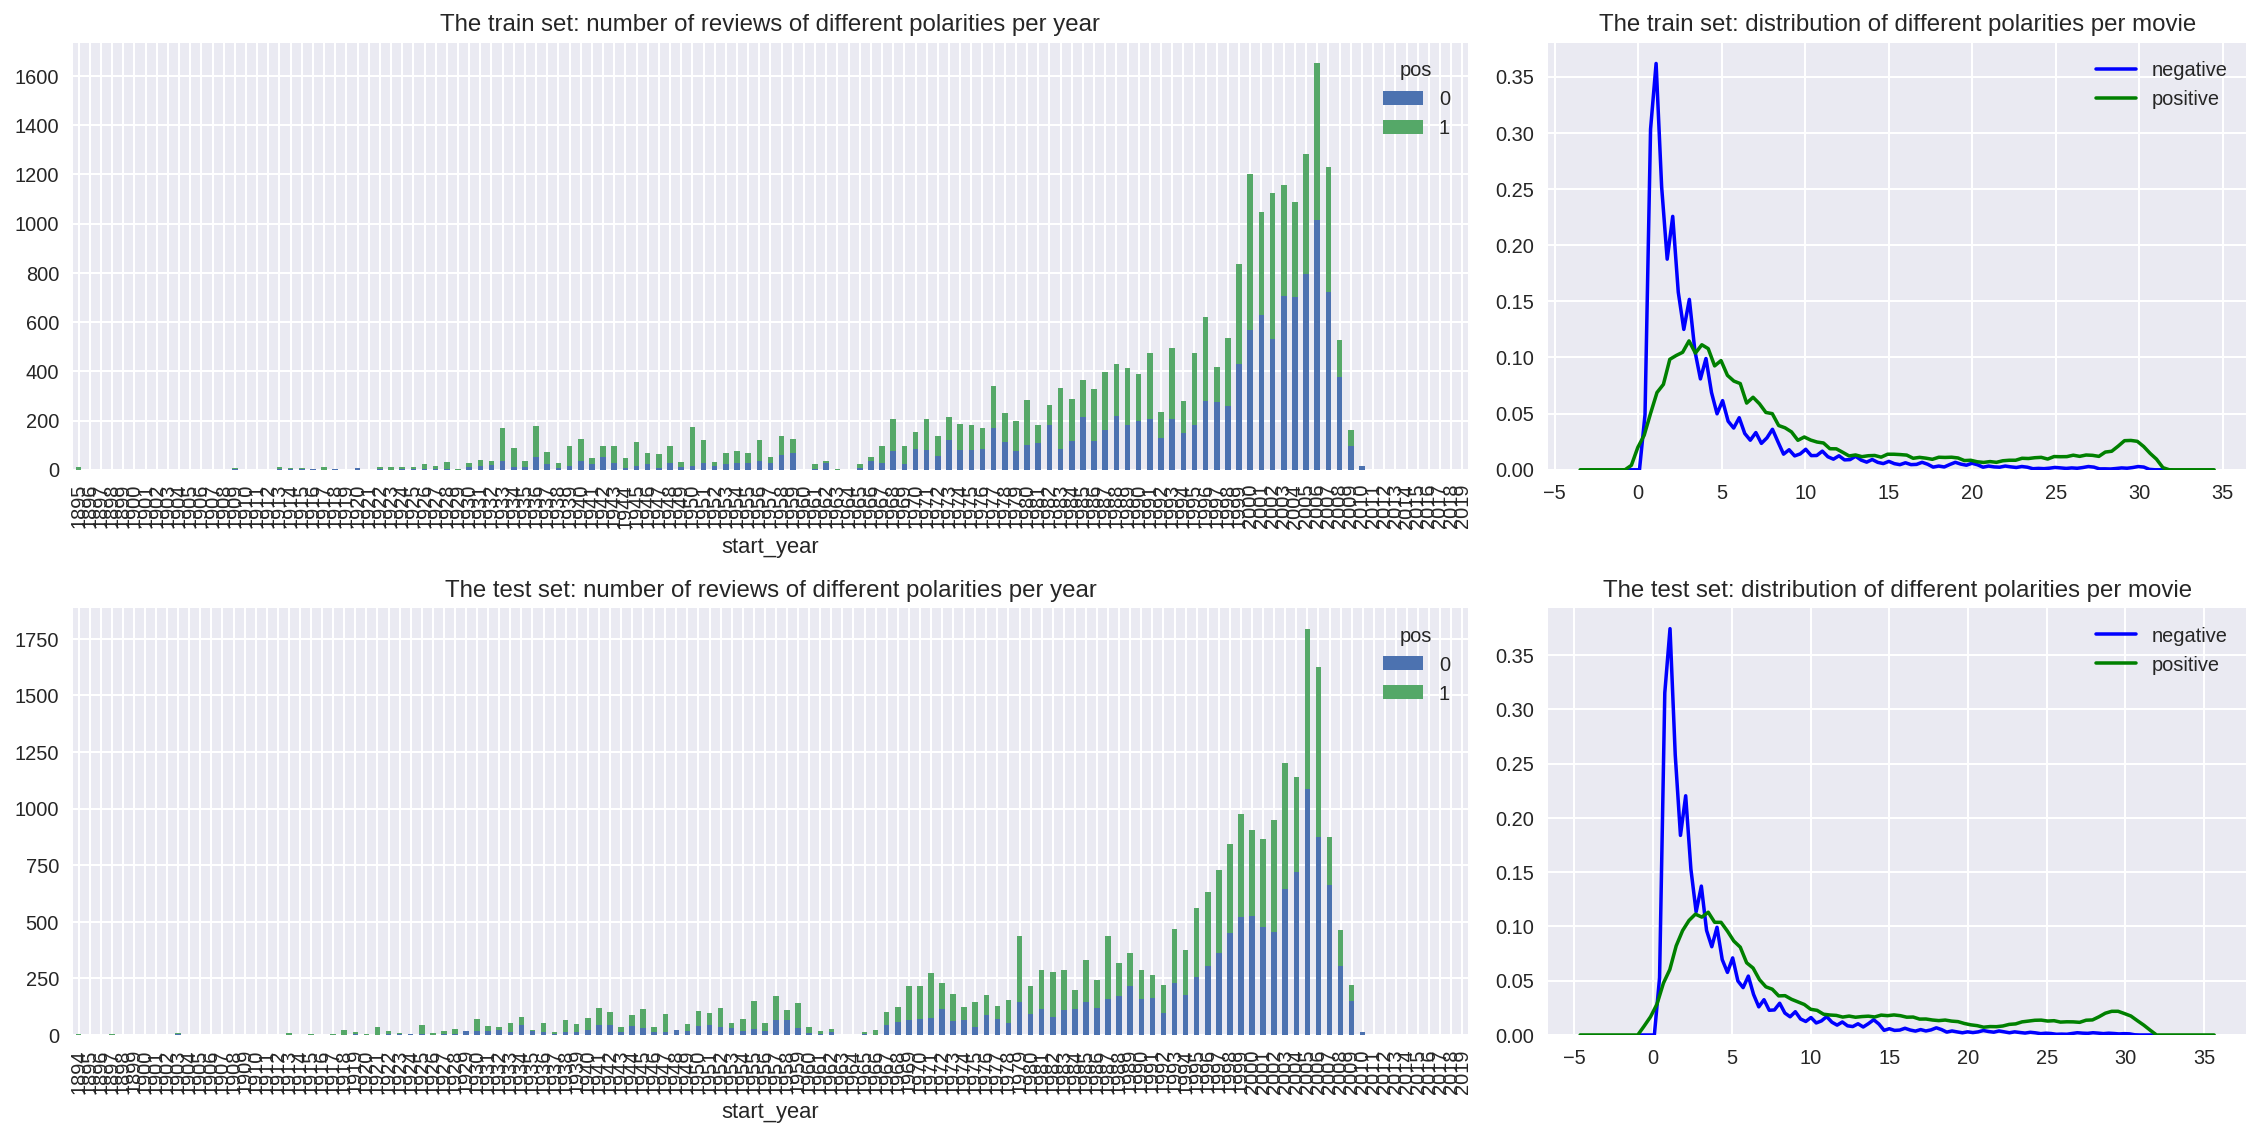

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [18]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [19]:
def lowerize(review):
    return review.lower()

df_reviews['review_norm'] = df_reviews['review'].apply(lowerize)

In [20]:
import re

def apply_pattern(review):
    pattern = r"[^a-z]"
    return re.sub(pattern, " ", review)
           
df_reviews['review_norm'] = df_reviews['review_norm'].apply(apply_pattern)

In [28]:
display(df_reviews)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx,review_norm
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335,the pakage implies that warren beatty and gold...
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336,how the hell did they get this made presenti...
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489,there is no real story the film seems more lik...
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280,um a serious film about troubled teens in...
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281,i m totally agree with garryjohal from singapo...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47326,tt0068398,tvEpisode,Étude in Black,Étude in Black,1972,\N,97,0,"Crime,Drama,Mystery",7.7,2254,This is another of my favorite Columbos. It sp...,10,pos,1,test,6038,this is another of my favorite columbos it sp...
47327,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,Talk about being boring! I got this expecting ...,4,neg,0,test,989,talk about being boring i got this expecting ...
47328,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,"I never thought I'd say this about a biopic, b...",8,pos,1,test,4163,i never thought i d say this about a biopic b...
47329,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,Spirit and Chaos is an artistic biopic of Miya...,9,pos,1,test,4164,spirit and chaos is an artistic biopic of miya...


## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [22]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Working with models

### Model 0 - Constant

In [23]:
from sklearn.dummy import DummyClassifier

In [24]:
#Creating encoded dataset.
encoder = LabelEncoder()
reviews_ordinal = df_reviews.copy()
reviews_ordinal['title_type'] = encoder.fit_transform(reviews_ordinal['title_type'])
reviews_ordinal['primary_title'] = encoder.fit_transform(reviews_ordinal['primary_title'])
reviews_ordinal['title_type'] = encoder.fit_transform(reviews_ordinal['title_type'])
reviews_ordinal['primary_title'] = encoder.fit_transform(reviews_ordinal['primary_title'])
reviews_ordinal['original_title'] = encoder.fit_transform(reviews_ordinal['original_title'])
reviews_ordinal['end_year'] = encoder.fit_transform(reviews_ordinal['end_year'])
reviews_ordinal['genres'] = encoder.fit_transform(reviews_ordinal['genres'])
reviews_ordinal['review'] = encoder.fit_transform(reviews_ordinal['review'])
reviews_ordinal['sp'] = encoder.fit_transform(reviews_ordinal['sp'])
reviews_ordinal['ds_part'] = encoder.fit_transform(reviews_ordinal['ds_part'])
reviews_ordinal['tconst'] = encoder.fit_transform(reviews_ordinal['tconst'])
display(reviews_ordinal)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx,review_norm
0,1191,0,0,0,1971,59,121,0,263,6.3,2218,33652,1,0,0,1,8335,the pakage implies that warren beatty and gold...
1,1191,0,0,0,1971,59,121,0,263,6.3,2218,11555,1,0,0,1,8336,how the hell did they get this made presenti...
2,4786,1,1,1,2002,59,25,0,288,6.3,184,34658,3,0,0,0,2489,there is no real story the film seems more lik...
3,4786,1,1,1,2002,59,25,0,288,6.3,184,42193,7,1,1,0,9280,um a serious film about troubled teens in...
4,4786,1,1,1,2002,59,25,0,288,6.3,184,20698,9,1,1,0,9281,i m totally agree with garryjohal from singapo...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47326,1209,2,6553,6559,1972,59,97,0,369,7.7,2254,37362,10,1,1,0,6038,this is another of my favorite columbos it sp...
47327,4104,4,6554,6560,1996,59,55,0,197,7.3,278,31380,4,0,0,0,989,talk about being boring i got this expecting ...
47328,4104,4,6554,6560,1996,59,55,0,197,7.3,278,16363,8,1,1,0,4163,i never thought i d say this about a biopic b...
47329,4104,4,6554,6560,1996,59,55,0,197,7.3,278,30787,9,1,1,0,4164,spirit and chaos is an artistic biopic of miya...


In [25]:
df_reviews_train_ordinal = reviews_ordinal.query('ds_part == "1"').copy()
df_reviews_test_ordinal = reviews_ordinal.query('ds_part == "0"').copy()
train_target_ordinal = df_reviews_train_ordinal['pos']
test_target_ordinal = df_reviews_test_ordinal['pos']
features_train_ordinal = df_reviews_train_ordinal.drop(['pos', 'review_norm'], axis=1)
features_test_ordinal = df_reviews_test_ordinal.drop(['pos', 'review_norm'], axis=1)

In [26]:
model_0 = DummyClassifier()
model_0.fit(features_train_ordinal, train_target_ordinal)
predictions = model_0.predict(features_test_ordinal)

          train  test
Accuracy   0.50   0.5
F1         0.51   0.5
APS        0.50   0.5
ROC AUC    0.50   0.5


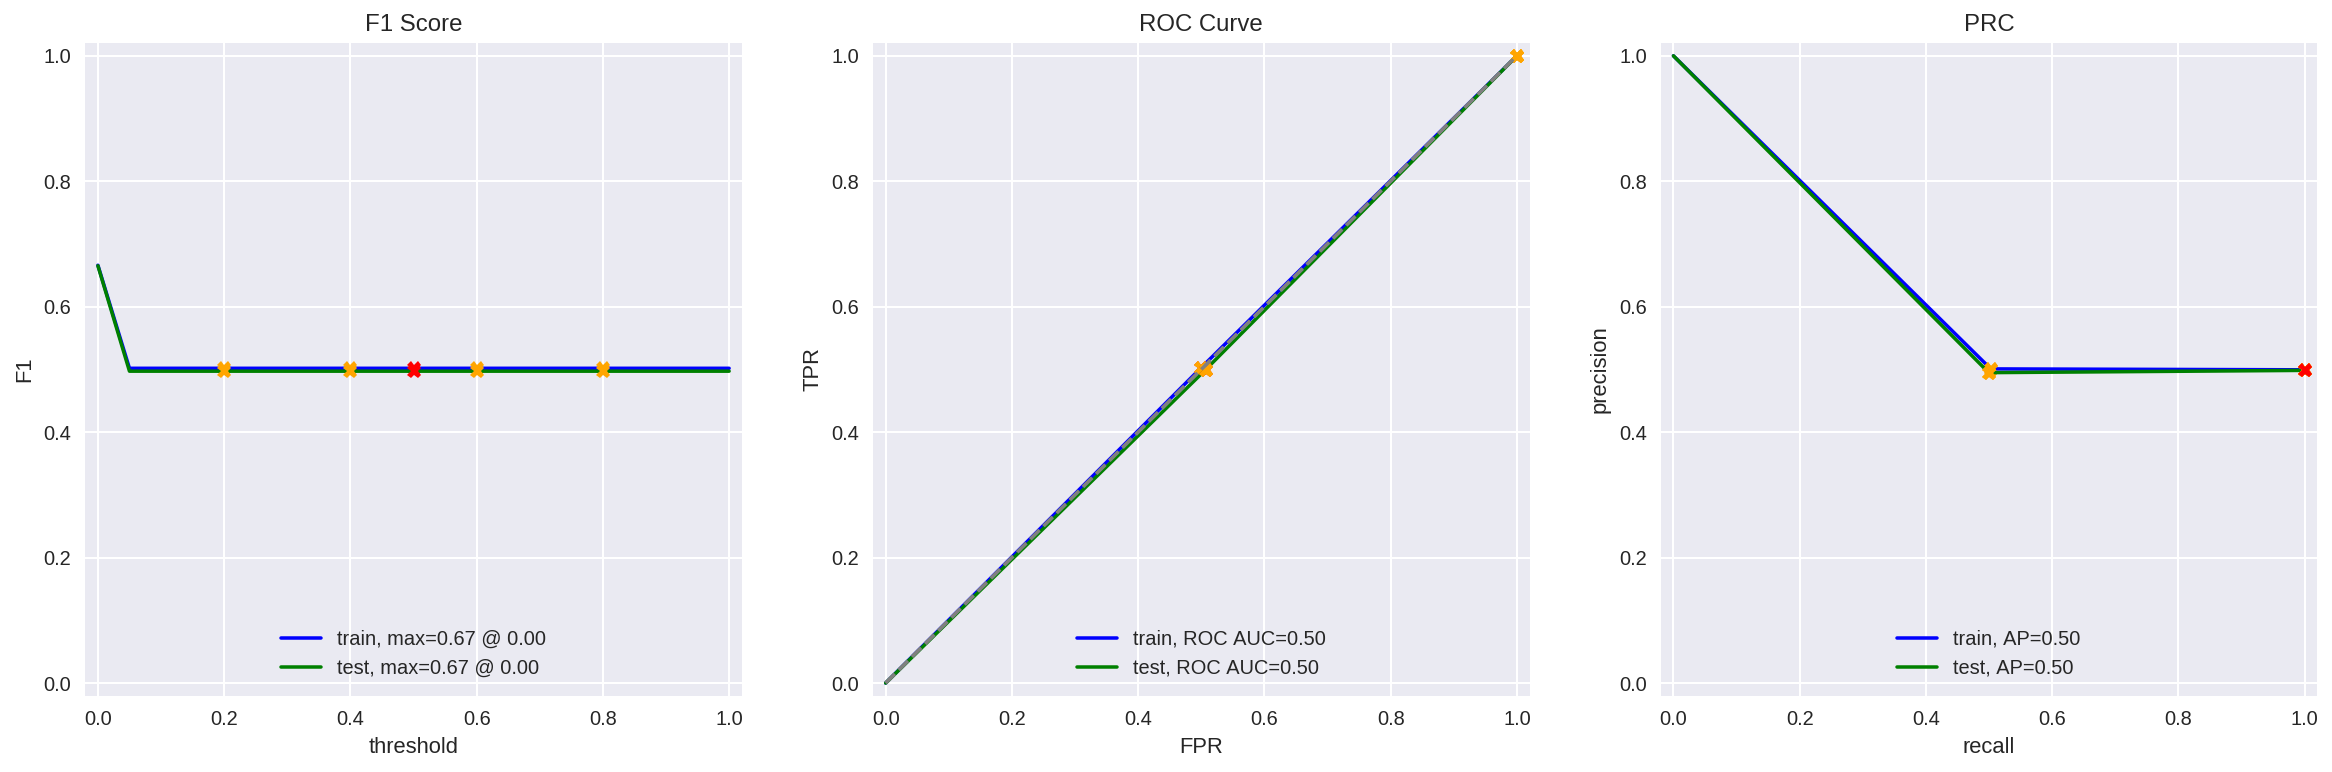

In [27]:
evaluate_model(model_0, features_train_ordinal, train_target_ordinal, features_test_ordinal, test_target_ordinal)

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [29]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [30]:
corpus_train = df_reviews_train['review_norm']
corpus_test = df_reviews_test['review_norm']

stop_words = set(stopwords.words('english'))
tfidf_vectorizer_2 = TfidfVectorizer(stop_words=stop_words) 
train_features_1 =  tfidf_vectorizer_2.fit_transform(corpus_train)
display(train_features_1)

<23796x71531 sparse matrix of type '<class 'numpy.float64'>'
	with 2332924 stored elements in Compressed Sparse Row format>

In [31]:
model_1 = LogisticRegression(solver='lbfgs')
model_1.fit(train_features_1, train_target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [32]:
test_features_1 =  tfidf_vectorizer_2.transform(corpus_test)
predictions = model_1.predict(test_features_1)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


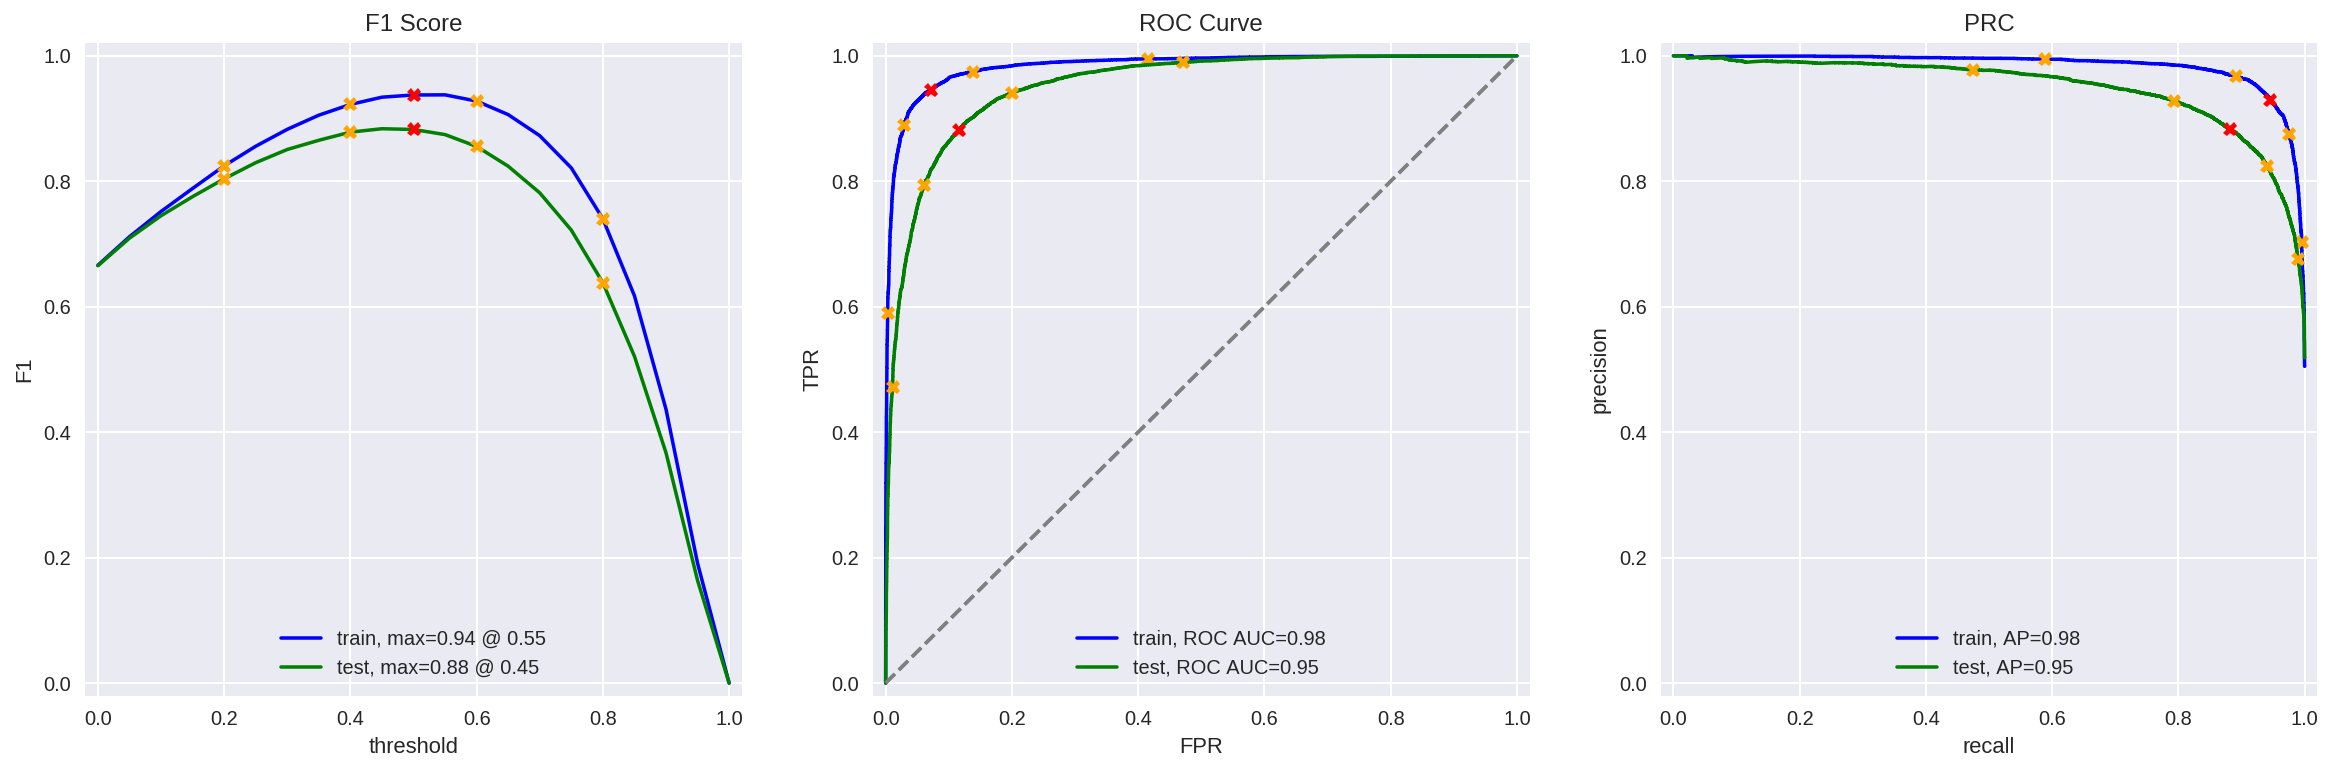

In [33]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

### Model 2 - spaCy, TF-IDF and LR

In [34]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [35]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [36]:
df_reviews['review_lemm'] = df_reviews['review_norm'].apply(text_preprocessing_3)

In [37]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

corpus_train = df_reviews_train['review_lemm']
corpus_test = df_reviews_test['review_lemm']

stop_words = set(stopwords.words('english'))
tfidf_vectorizer_3 = TfidfVectorizer(stop_words=stop_words) 
train_features_2 =  tfidf_vectorizer_3.fit_transform(corpus_train)
display(train_features_2)

<23796x60581 sparse matrix of type '<class 'numpy.float64'>'
	with 2252717 stored elements in Compressed Sparse Row format>

In [38]:
model_2 = LogisticRegression(solver='lbfgs')
model_2.fit(train_features_2, train_target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [39]:
test_features_2 =  tfidf_vectorizer_3.transform(corpus_test)
predictions = model_2.predict(test_features_2)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


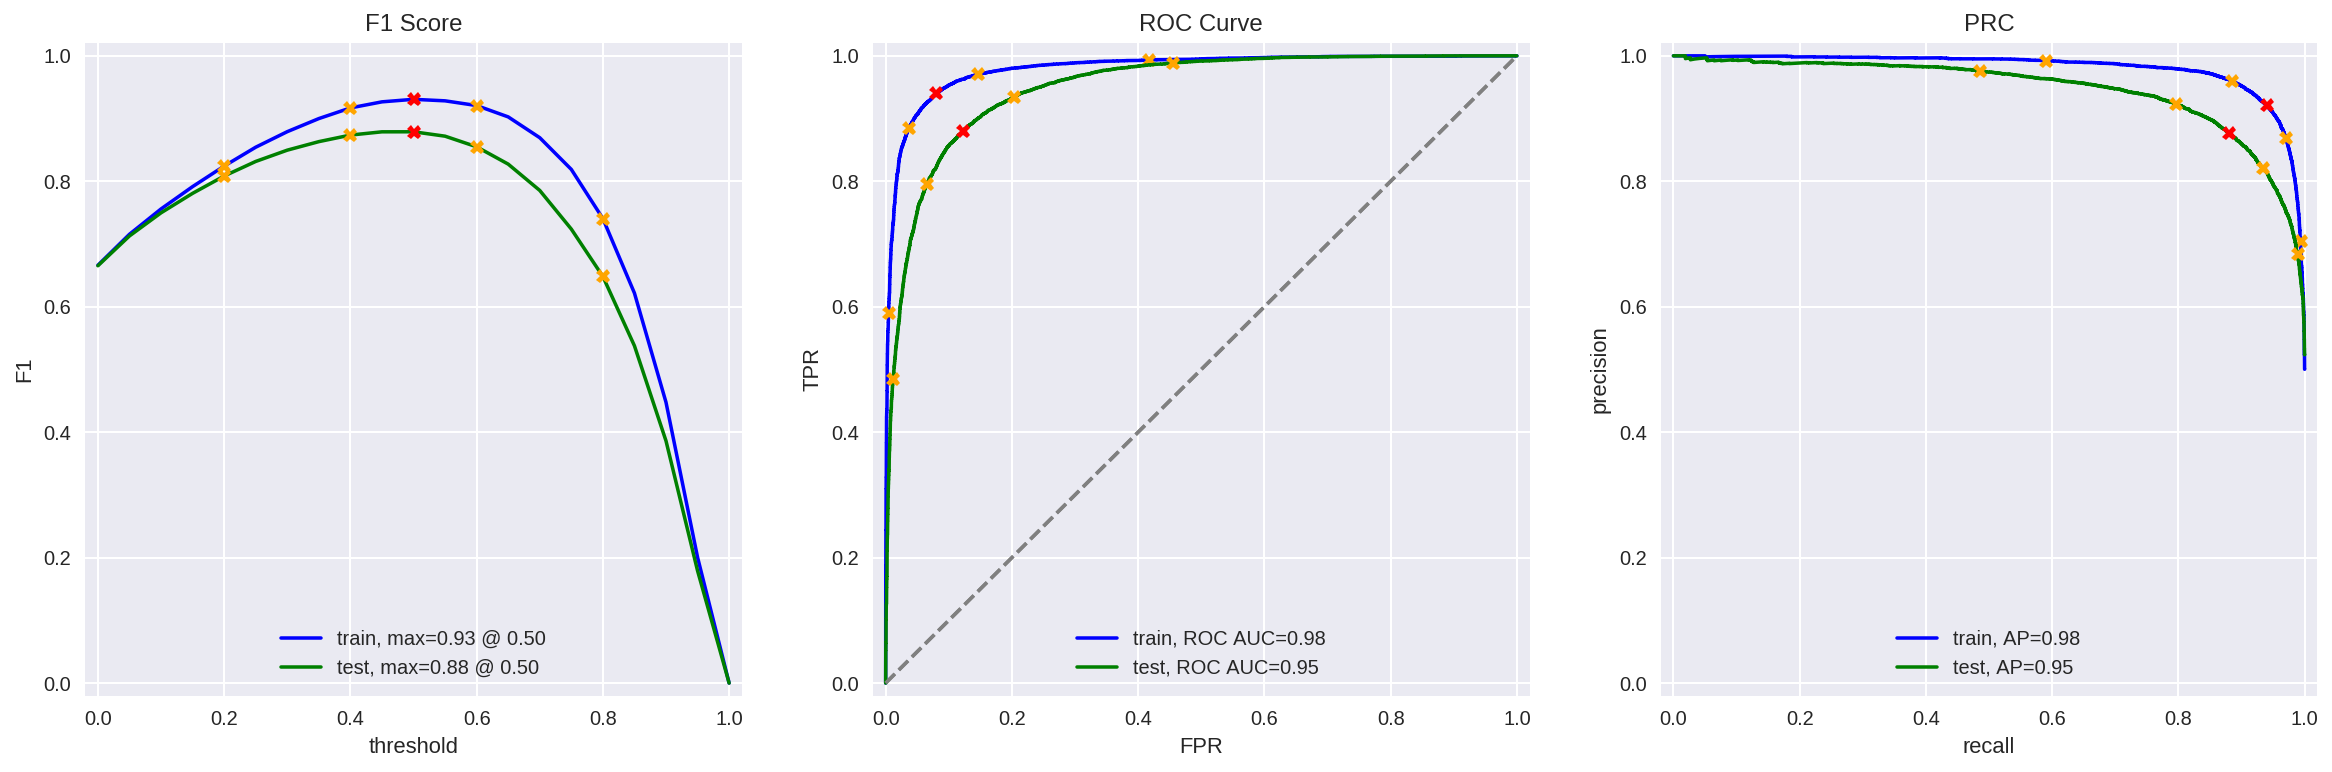

In [40]:
evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

### Model 3 - spaCy, TF-IDF and LGBMClassifier

In [41]:
from lightgbm import LGBMClassifier

In [42]:
stop_words = set(stopwords.words('english'))
tfidf_vectorizer_4 = TfidfVectorizer(stop_words=stop_words) 
train_features_3 =  tfidf_vectorizer_4.fit_transform(corpus_train)
display(train_features_3)

<23796x60581 sparse matrix of type '<class 'numpy.float64'>'
	with 2252717 stored elements in Compressed Sparse Row format>

In [43]:
model_3 = LGBMClassifier()
model_3.fit(train_features_3, train_target)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [44]:
test_features_3 =  tfidf_vectorizer_4.transform(corpus_test)
predictions = model_3.predict(test_features_3)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          train  test
Accuracy   0.91  0.86
F1         0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.94


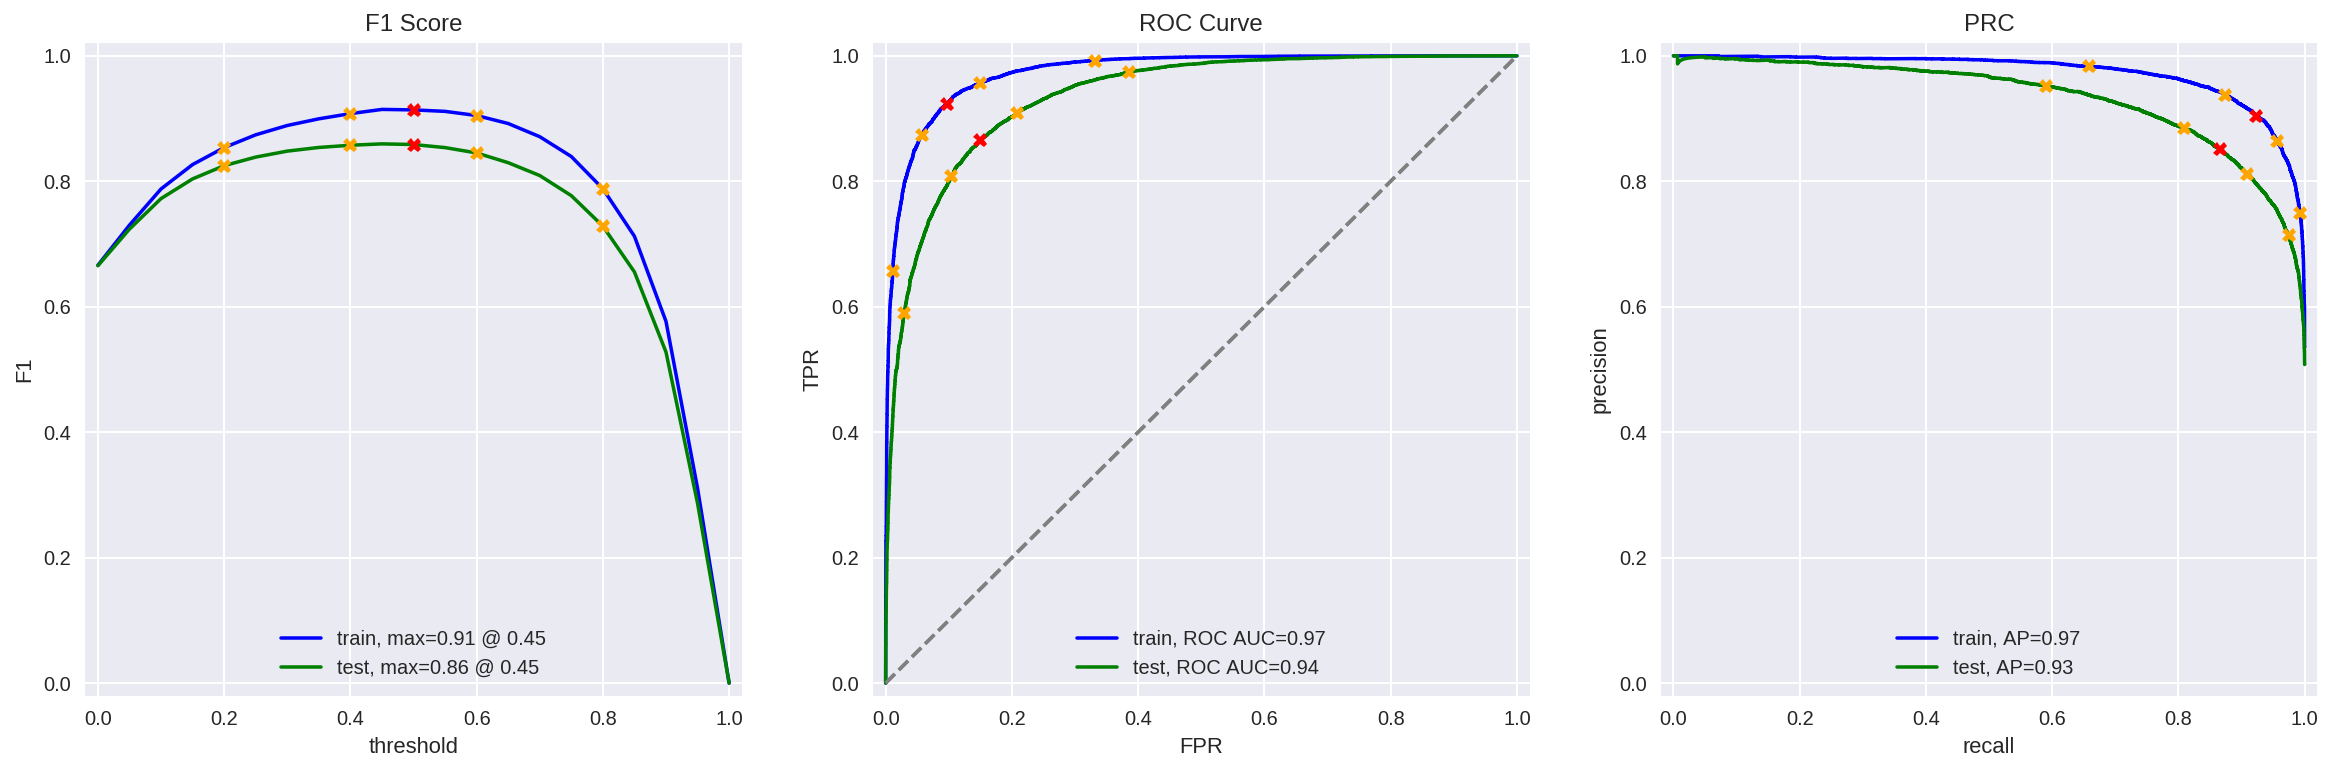

In [45]:
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

###  Model 9 - BERT

In [46]:
import torch
import transformers

In [47]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [48]:
def BERT_text_to_embeddings(texts, max_length=100, batch_size=25, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []
    max_sample_size = 500

    
    for input_text in df_reviews.iloc[:max_sample_size]['review']:
        ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids + [0]*(max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [49]:
# Attention! Running BERT for thousands of texts may take long run on CPU.
train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cpu')

Using the cpu device.


In [50]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

(23796,)
(500, 768)
(23796,)


In [51]:
max_sample_size = 500
features = train_features_9
target = df_reviews.iloc[:max_sample_size]['pos']

print(features.shape)
print(target.shape)

(500, 768)
(500,)


In [52]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.5, random_state=42) 
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(250, 768)
(250, 768)
(250,)
(250,)


In [53]:
# train and test your model
model_9 = LogisticRegression(solver='lbfgs')
model_9.fit(X_train,y_train)
model_9.predict(X_test)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


array([1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 0])

In [54]:
# saving embeddings
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# and load...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          train  test
Accuracy    1.0  0.78
F1          1.0  0.77
APS         1.0  0.78
ROC AUC     1.0  0.84


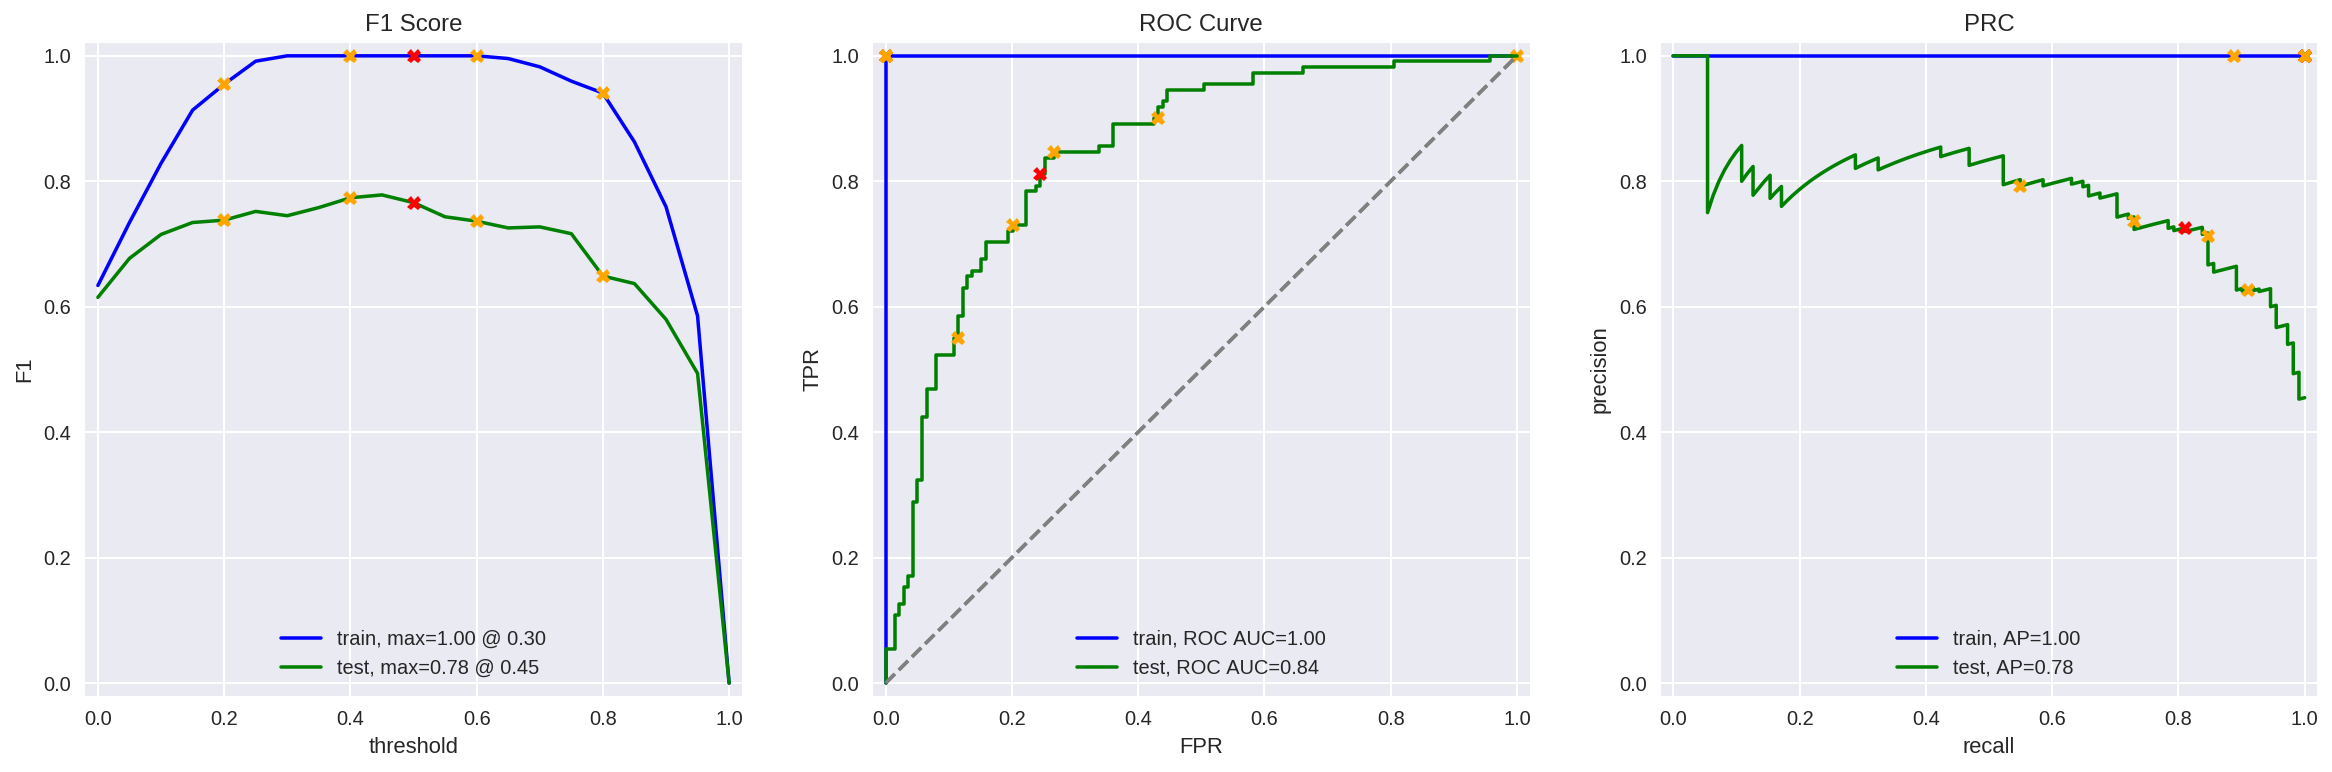

In [55]:
evaluate_model(model_9, X_train, y_train, X_test, y_test)

## My Reviews

In [61]:
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.',
    'The movie was hilarious, the actors made me laugh from start to finish of the play',
    'Bad storyline, bad acting, I was really horrified, worst film ever made.',
    "It would be a shame to don't see this movie.",
    'Anyone who is ever watched Sophie Turner on "Game of Thrones" should know that she cannot carry a movie. She is lovely, but has one expression.',
    'A sophomorically conceived film that tries to push every cliched button of the politically correct lunatics that fuel modern Hollywood philosophies. A film that gets into so many false premises that it should have been a black comedy had the filmmakers had the intellectual maturity to satirize such immature writing. Yuk.',
    'What a turkey! A dried up, emaciated and leathery old turkey not even worth cooking. Should have been left for the buzzards. When Pierce Brosnan uttered the zinger when conducting the initial examination, I thought, no way. If this was the premise, why a ham-fisted line like that. Against my better judgement I persisted. Silly me.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(lowerize)
my_reviews['review_norm'] = my_reviews['review_norm'].apply(apply_pattern)

### Model 1

In [62]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(tfidf_vectorizer_2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.14:  i did not simply like it  not my kind of movie 
0.16:  well  i was bored and felt asleep in the middle of the movie 
0.54:  i was really fascinated with the movie
0.11:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.31:  i didn t expect the reboot to be so good  writers really cared about the source material
0.47:  the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see my
0.04:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.82:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi
0.63:  the movie was hilarious  the actors made me laugh from start to finish of the play
0.00:  bad storyline  bad acting  i was really horrified  worst film ever made 
0.20:  it would be a shame to don t see this movie 
0.59:  anyone who is ever watched sophie turner on  game of thrones  should know

### Model 2

In [63]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.27:  i did not simply like it  not my kind of movie 
0.10:  well  i was bored and felt asleep in the middle of the movie 
0.43:  i was really fascinated with the movie
0.08:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.23:  i didn t expect the reboot to be so good  writers really cared about the source material
0.57:  the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see my
0.03:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.91:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi
0.61:  the movie was hilarious  the actors made me laugh from start to finish of the play
0.00:  bad storyline  bad acting  i was really horrified  worst film ever made 
0.19:  it would be a shame to don t see this movie 
0.77:  anyone who is ever watched sophie turner on  game of thrones  should know

### Model 3

In [64]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.67:  i did not simply like it  not my kind of movie 
0.33:  well  i was bored and felt asleep in the middle of the movie 
0.60:  i was really fascinated with the movie
0.34:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.62:  i didn t expect the reboot to be so good  writers really cared about the source material
0.70:  the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see my
0.25:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.78:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi
0.73:  the movie was hilarious  the actors made me laugh from start to finish of the play
0.11:  bad storyline  bad acting  i was really horrified  worst film ever made 
0.68:  it would be a shame to don t see this movie 
0.60:  anyone who is ever watched sophie turner on  game of thrones  should know

### Model 9

In [65]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.00:  i did not simply like it  not my kind of movie 
0.11:  well  i was bored and felt asleep in the middle of the movie 
0.99:  i was really fascinated with the movie
0.80:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.93:  i didn t expect the reboot to be so good  writers really cared about the source material
0.96:  the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see my
0.25:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.23:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi
0.11:  the movie was hilarious  the actors made me laugh from start to finish of the play
0.80:  bad storyline  bad acting  i was really horrified  worst film ever made 
0.51:  it would be a shame to don t see this movie 
0.07:  anyone who is ever watched sophie turner on  game of thrones  should know

## Conclusions

After loading data, I decided to don't process the data at all since there were no duplicates and the 2 NaN could just be ignored since they didn't affected the model building. Within EDA I checked for the 'pos' column balance and the classes were correctly balanced, almost 50/50.

Started to buid models. The results coming from model buildings were:
- NLTK, TF-IDF and LR got F1 0.94 (train) 0.88 (test)
- Spacy, TF-IDF and LR got F1 0.93 (train) 0.88 (test)
- Spacy, TF-IDF and LGBM got F1 0.91 (train) 0.86 (test)
- BERT obtained F1 1.0 (train) and 0.77 (test)

BERT was the only model to don't accomplish at least 0.85 in testing phase as F1 score but this depended on the fact that my BERT model was obtained just on a 500 sample (since working on CPU), I am pretty sure that training the model on the entire dataset the threshold is going to get reached and probably this model can accomplish even better results compared to the others.

My last statement could be confirmed by the reviews probabilities, the other models correctly classified the majority of my reviews, but they found difficulties while classifiyng false positive comments. Being BERT an algorithm that takes in consideration the words significate within the context, it was able to classify correctly all the reviews and was able as well to understand that the last three reviews where false positive returning probabilities near to zero for them.

# Checklist

- [x]  Notebook was opened
- [x]  The text data is loaded and pre-processed for vectorization
- [x]  The text data is transformed to vectors
- [x]  Models are trained and tested
- [x]  The metric's threshold is reached
- [x]  All the code cells are arranged in the order of their execution
- [x]  All the code cells can be executed without errors
- [x]  There are conclusions